# Linear fascicle evaluation (LiFE)

Evaluating the results of tractography algorithms is one of the biggest
challenges for diffusion MRI. One proposal for evaluation of tractography
results is to use a forward model that predicts the signal from each of a set of
streamlines, and then fit a linear model to these simultaneous predictions
[Pestilli2014].

We will use streamlines generated in the tracking notebook.

In [1]:
import numpy as np
import os.path as op
import nibabel as nib
import dipy.core.optimize as opt
from streamline_tools import *
# We'll need to know where the corpus callosum is from these variables:
from dipy.data import (read_stanford_labels,
                       fetch_stanford_t1,
                       read_stanford_t1)
hardi_img, gtab, labels_img = read_stanford_labels()
labels = labels_img.get_data()
cc_slice = labels == 2
fetch_stanford_t1()
t1 = read_stanford_t1()
t1_data = t1.get_data()
data = hardi_img.get_data()

# Read the candidates from file in voxel space:
candidate_sl = [s[0] for s in nib.trackvis.read('CSD_prob.trk', points_space='voxel')[0]]

# Filter for streamlines that have 10 nodes or more:
candidate_sl = [s for s in candidate_sl if len(s) > 10]

Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/.dipy/stanford_hardi 


The streamlines that are entered into the model are termed 'candidate
streamliness' (or a 'candidate connectome').

Let's visualize the initial candidate group of streamlines in 3D, relative to the
anatomical structure of this brain:

In [2]:
from dipy.viz.colormap import line_colors
from dipy.viz import fvtk
candidate_streamlines_actor = fvtk.streamtube(candidate_sl,
                                       line_colors(candidate_sl))
cc_ROI_actor = fvtk.contour(cc_slice, levels=[1], colors=[(1., 1., 0.)],
                            opacities=[1.])

vol_actor = fvtk.slicer(t1_data)

vol_actor.display(40, None, None)
vol_actor2 = vol_actor.copy()
vol_actor2.display(None, None, 35)

# Add display objects to canvas
ren = fvtk.ren()
fvtk.add(ren, candidate_streamlines_actor)
fvtk.add(ren, cc_ROI_actor)
fvtk.add(ren, vol_actor)
fvtk.add(ren, vol_actor2)
fvtk.record(ren, n_frames=1, out_path='life_candidates.png',
            size=(800, 800))


In [3]:
from IPython.display import display, Image

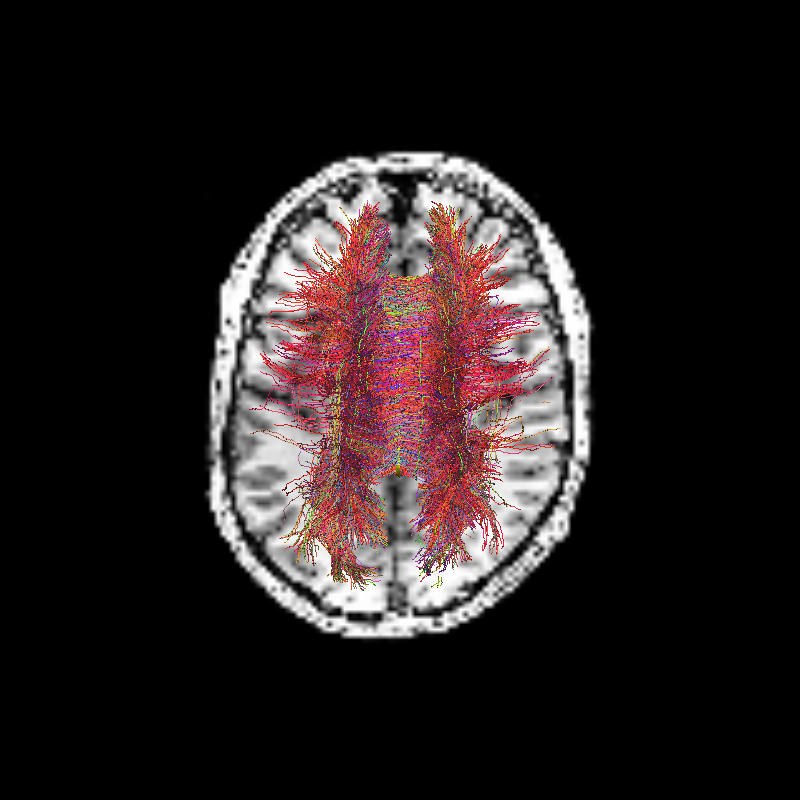

In [4]:
display(Image('life_candidates.png'))

Next, we initialize a LiFE model. We import the `dipy.tracking.life` module,
which contains the classes and functions that implement the model:


In [5]:
import dipy.tracking.life as life
fiber_model = life.FiberModel(gtab)

Since we read the streamlines from a file, already in the voxel space, we do not
need to transform them into this space. Otherwise, if the streamline coordinates
were in the world space (relative to the scanner iso-center, or relative to the
mid-point of the AC-PC-connecting line), we would use this::

    inv_affine = np.linalg.inv(hardi_img.get_affine())

the inverse transformation from world space to the voxel space as the affine for
the following model fit.

The next step is to fit the model, producing a `FiberFit` class instance, that
stores the data, as well as the results of the fitting procedure.

The LiFE model posits that the signal in the diffusion MRI volume can be
explained by the streamlines, by the equation

$y = X\beta$

Where $y$ is the diffusion MRI signal, $\beta$ are a set of weights on the
streamlines and $X$ is a design matrix. This matrix has the dimensions $m$ by
$n$, where $m=n_{voxels} \cdot n_{directions}$, and $n_{voxels}$ is the set of
voxels in the ROI that contains the streamlines considered in this model. The
$i^{th}$ column of the matrix contains the expected contributions of the
$i^{th}$ streamline (arbitrarly ordered) to each of the voxels. $X$ is a sparse
matrix, because each streamline traverses only a small percentage of the
voxels. The  expected contributions of the streamline are calculated using a
forward model, where each node of the streamline is modeled as a cylindrical
fiber compartment with Gaussian diffusion, using the diffusion tensor model. See
[Pestilli2014]_ for more detail on the model, and variations of this model.

In [6]:
fiber_fit = fiber_model.fit(data, candidate_sl, affine=np.eye(4))

The `FiberFit` class instance holds various properties of the model fit. For
example, it has the weights $\beta$, that are assigned to each streamline. In
most cases, a tractography through some region will include redundant
streamlines, and these streamlines will have $\beta_i$ that are 0.

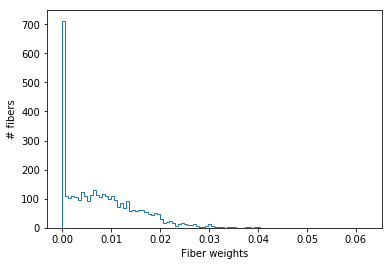

In [7]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
fig, ax = plt.subplots(1)
ax.hist(fiber_fit.beta, bins=100, histtype='step')
ax.set_xlabel('Fiber weights')
ax.set_ylabel('# fibers')
fig.savefig('beta_histogram.png')

We use $\beta$ to filter out these redundant streamlines, and generate an
optimized group of streamlines:

In [8]:
optimized_sl = list(np.array(candidate_sl)[np.where(fiber_fit.beta>0)[0]])
ren = fvtk.ren()
fvtk.add(ren, fvtk.streamtube(optimized_sl, line_colors(optimized_sl)))
fvtk.add(ren, cc_ROI_actor)
fvtk.add(ren, vol_actor)
fvtk.record(ren, n_frames=1, out_path='life_optimized.png',
            size=(800, 800))

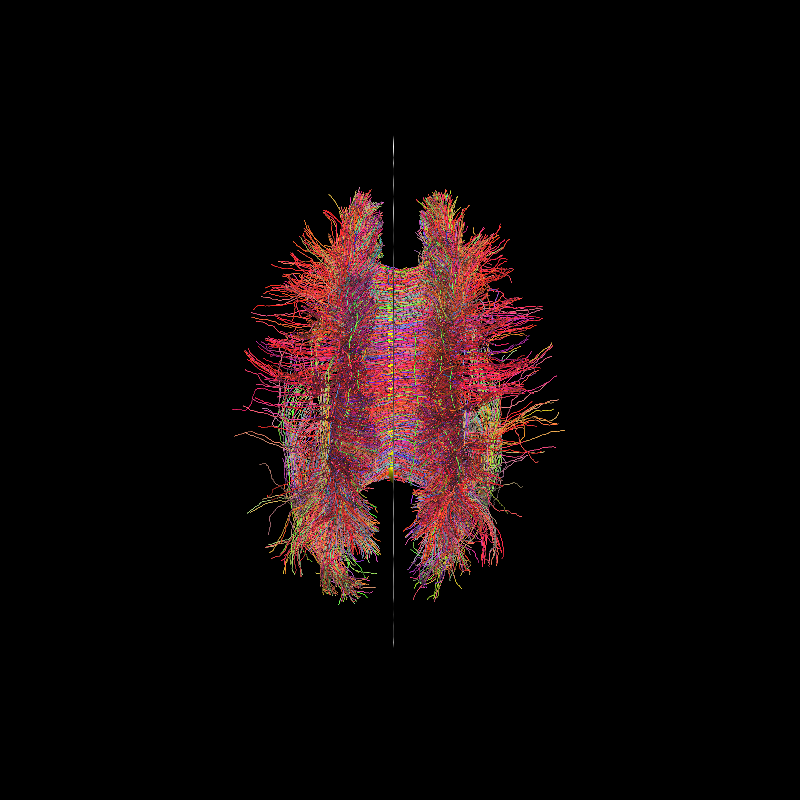

In [9]:
display(Image('life_optimized.png'))

The new set of streamlines should do well in fitting the data, and redundant
streamlines have presumably been removed (in this case, about 50% of the
streamlines).

But how well does the model do in explaining the diffusion data? We can
quantify that: the `FiberFit` class instance has a `predict` method, which can
be used to invert the model and predict back either the data that was used to
fit the model, or other unseen data (e.g. in cross-validation, see
:ref:`kfold_xval`).

Without arguments, the `.predict()` method will predict the diffusion signal
for the same gradient table that was used in the fit data, but `gtab` and `S0`
key-word arguments can be used to predict for other acquisition schemes and
other baseline non-diffusion-weighted signals.

In [10]:
model_predict = fiber_fit.predict()

We will focus on the error in prediction of the diffusion-weighted data, and
calculate the root of the mean squared error.

In [11]:
model_error = model_predict - fiber_fit.data
model_rmse = np.sqrt(np.mean(model_error[:, 10:] ** 2, -1))

As a baseline against which we can compare, we calculate another error term. In
this case, we assume that the weight for each streamline is equal
to zero. This produces the naive prediction of the mean of the signal in each
voxel.

In [12]:
beta_baseline = np.zeros(fiber_fit.beta.shape[0])
pred_weighted = np.reshape(opt.spdot(fiber_fit.life_matrix, beta_baseline),
                                     (fiber_fit.vox_coords.shape[0],
                                      np.sum(~gtab.b0s_mask)))
mean_pred = np.empty((fiber_fit.vox_coords.shape[0], gtab.bvals.shape[0]))
S0 = fiber_fit.b0_signal

Since the fitting is done in the demeaned S/S0 domain, we need
to add back the mean and then multiply by S0 in every voxel:

In [13]:
mean_pred[..., gtab.b0s_mask] = S0[:, None]
mean_pred[..., ~gtab.b0s_mask] =\
        (pred_weighted + fiber_fit.mean_signal[:, None]) * S0[:, None]
mean_error = mean_pred - fiber_fit.data
mean_rmse = np.sqrt(np.mean(mean_error ** 2, -1))

First, we can compare the overall distribution of errors between these two
alternative models of the ROI. We show the distribution of differences in error
(improvement through model fitting, relative to the baseline model). Here,
positive values denote an improvement in error with model fit, relative to
without the model fit.

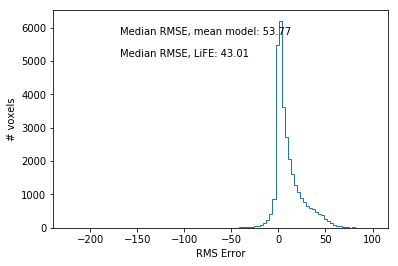

In [14]:
fig, ax = plt.subplots(1)
ax.hist(mean_rmse - model_rmse, bins=100, histtype='step')
ax.text(0.2, 0.9,'Median RMSE, mean model: %.2f' % np.median(mean_rmse),
     horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes)
ax.text(0.2, 0.8,'Median RMSE, LiFE: %.2f' % np.median(model_rmse),
     horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes)
ax.set_xlabel('RMS Error')
ax.set_ylabel('# voxels')
fig.savefig('error_histograms.png')

Second, we can show the spatial distribution of the two error terms,
and of the improvement with the model fit:

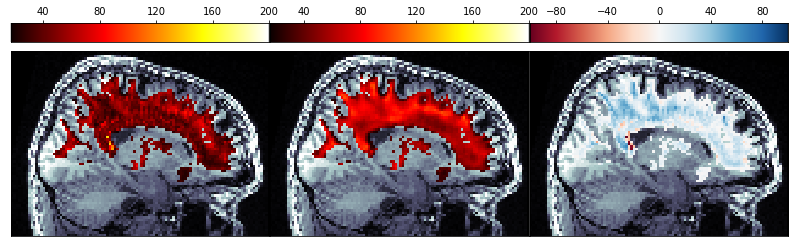

In [15]:
vol_model = np.ones(data.shape[:3]) * np.nan
vol_model[fiber_fit.vox_coords[:, 0],
          fiber_fit.vox_coords[:, 1],
          fiber_fit.vox_coords[:, 2]] = model_rmse
vol_mean = np.ones(data.shape[:3]) * np.nan
vol_mean[fiber_fit.vox_coords[:, 0],
         fiber_fit.vox_coords[:, 1],
         fiber_fit.vox_coords[:, 2]] = mean_rmse
vol_improve = np.ones(data.shape[:3]) * np.nan
vol_improve[fiber_fit.vox_coords[:, 0],
            fiber_fit.vox_coords[:, 1],
            fiber_fit.vox_coords[:, 2]] = mean_rmse - model_rmse
sl_idx = 49

from mpl_toolkits.axes_grid1 import AxesGrid
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95)
ax = AxesGrid(fig, 111,
              nrows_ncols = (1, 3),
              label_mode = "1",
              share_all = True,
              cbar_location="top",
              cbar_mode="each",
              cbar_size="10%",
              cbar_pad="5%")
ax[0].matshow(np.rot90(t1_data[sl_idx, :, :]), cmap=matplotlib.cm.bone)
im = ax[0].matshow(np.rot90(vol_model[sl_idx, :, :]), cmap=matplotlib.cm.hot, vmax=200)
ax.cbar_axes[0].colorbar(im)
ax[1].matshow(np.rot90(t1_data[sl_idx, :, :]), cmap=matplotlib.cm.bone)
im = ax[1].matshow(np.rot90(vol_mean[sl_idx, :, :]), cmap=matplotlib.cm.hot, vmax=200)
ax.cbar_axes[1].colorbar(im)
ax[2].matshow(np.rot90(t1_data[sl_idx, :, :]), cmap=matplotlib.cm.bone)
im = ax[2].matshow(np.rot90(vol_improve[sl_idx, :, :]), cmap=matplotlib.cm.RdBu, vmax=100, vmin=-100)
ax.cbar_axes[2].colorbar(im)
for lax in ax:
    lax.set_xticks([])
    lax.set_yticks([])
fig.set_size_inches([12, 12])

This image demonstrates that in many places, fitting the LiFE model results in
substantial reduction of the error.

For the Matlab implementation of LiFE, head over to [Franco Pestilli's github webpage](https://github.com/brain-life/encode).

### References

[Pestilli, F., Yeatman, J, Rokem, A. Kay, K. and Wandell B.A. (2014). Validation and statistical inference in living connectomes. Nature Methods 11:1058-1063. doi:10.1038/nmeth.3098](http://arokem.org/publications/papers/Pestilli2014LiFE.pdf)
